<a href="https://colab.research.google.com/github/Hotckiss/DUL/blob/hw3_2/hw3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import pickle

import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

path_ = os.path.join('drive', 'My Drive', 'hw3-q2.pkl')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
def plot_data(n, train, validate, title_):
    ax = plt.subplot(111)
    ax.plot(range(n), train, label='train')
    ax.plot(range(n), validate, label='val')
    ax.set_xlabel("n")
    ax.set_title(title_)
    ax.legend()

In [0]:
def read_data():
    with open(path_, 'rb') as in_file:
        data = pickle.load(in_file)

    return data['train'], data['valid']

In [0]:
def transform(x):
    return (torch.tensor(x, dtype=torch.float32) * 2 / 255 - 1).permute(0, 3, 1, 2)

In [0]:
def KLDiv(mu, var):
    return (-0.5 * (1.0 + torch.log(var) - mu ** 2 - var)).mean()

In [0]:
def MLLLoss(mu, var, x):
    return (0.5 * (torch.log(np.pi * 2 * var) + (x - mu) ** 2 / var)).mean()

In [0]:
class GatedShortcutConnection(nn.Module):
    def __init__(self, channels=128):
        super(GatedShortcutConnection, self).__init__()
                 
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
                 
    def forward(self, x):
        return self.conv1(x) * self.sigmoid(self.conv2(x))

In [0]:
class ResidualStack(nn.Module):
    def __init__(self, channels=64):
        super(ResidualStack, self).__init__()      
        self.net = nn.Sequential(
            nn.Conv2d(4 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU()
        )
                 
    def forward(self, x):
        return self.net(x)

In [0]:
class VAE(nn.Module):
    def __init__(self, channels=32):
        super(VAE, self).__init__()
        self.channels = channels
        self.encoder = nn.Sequential(
            nn.Conv2d(3, self.channels * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(self.channels * 2, self.channels * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(self.channels * 4, self.channels * 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            ResidualStack(self.channels),
            nn.Conv2d(self.channels * 2, self.channels * 4, kernel_size=1)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(self.channels * 2, self.channels * 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            ResidualStack(self.channels),
            nn.ConvTranspose2d(self.channels * 2, self.channels * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(self.channels * 2, 3 * 2, kernel_size=4, stride=2, padding=1, bias=False)
        )
            
    def encode(self, x):
        x = self.encoder(x).reshape(-1, 2, 2 * self.channels, 8, 8)
        mu, var = x[:, 0], torch.exp(x[:, 1])
        z = mu + torch.sqrt(var) * torch.randn_like(mu, device=device)
        return mu, var, z
    
    def decode(self, z):
        z = self.decoder(z).reshape(-1, 2, 3, 32, 32)
        return z[:, 0], torch.exp(z[:, 1])
            
    def forward(self, x):
        mu_z, var_z, z = self.encode(x)
        mu_x, var_x = self.decode(z)
        return mu_z, var_z, mu_x, var_x

In [0]:
X_train, X_val = read_data()

In [0]:
batch_size = 1024

In [0]:
train_loader = data.DataLoader(dataset=X_train, batch_size=batch_size, shuffle=True, collate_fn=transform)
val_loader = data.DataLoader(dataset=X_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [0]:
epochs = 5

In [0]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [0]:
def train():
    KLD_t, losses_t, var_t, KLD_v, losses_v, var_v = [], [], [], [], [], []

    for i in trange(epochs):
        it_var, it_KLD, it_loss = [], [], []
        model.train()
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            mu_z, var_z, mu_x, var_x = model(x)
            mll, KL = MLLLoss(mu_x, var_x, x), KLDiv(mu_z, var_z)
            total_loss = mll + KL

            it_var.append(mll.item())
            it_KLD.append(KL.item())
            it_loss.append(total_loss.item())

            total_loss.backward()
            optimizer.step()

        var_t.append(np.array(it_var).mean())
        KLD_t.append(np.array(it_KLD).mean())
        losses_t.append(np.array(it_loss).mean())
        it_var, it_KLD, it_loss = [], [], []

        model.eval()
        with torch.no_grad():
            for x in val_loader:
                x = x.to(device)
                mu_z, var_z, mu_x, var_x = model(x)
                mll, KL = MLLLoss(mu_x, var_x, x), KLDiv(mu_z, var_z)
                total_loss = mll + KL

                it_var.append(mll.item())
                it_KLD.append(KL.item())
                it_loss.append(total_loss.item())

        var_v.append(np.array(it_var).mean())
        KLD_v.append(np.array(it_KLD).mean())
        losses_v.append(np.array(it_loss).mean())

    return var_t, var_v, KLD_t, KLD_v, losses_t, losses_v

In [109]:
var_t, var_v, KLD_t, KLD_v, losses_t, losses_v = train()

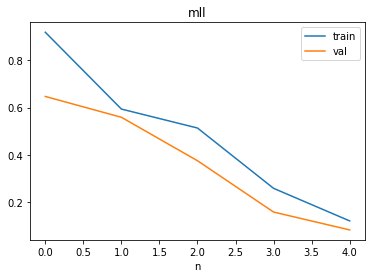

In [113]:
plot_data(epochs, var_t, var_v, "mll")

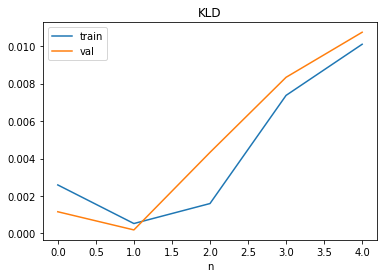

In [111]:
plot_data(epochs, KLD_t, KLD_v, "KLD")

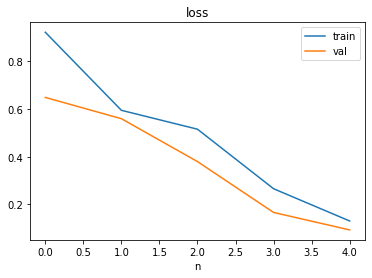

In [112]:
plot_data(epochs, losses_t, losses_v, "loss")